# Autoencoder + Transformer Hybrid Model with SHAP Analysis

In [1]:
# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

2025-01-16 17:50:24.692302: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 17:50:24.710138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 17:50:24.900744: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 17:50:24.902355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 17:50:25.440383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Step 1: Data Loading

In [2]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [3]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Define Autoencoder + Transformer Hybrid Model

In [4]:
def build_combined_model(input_dim):
    # Autoencoder Encoder
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    encoded = layers.Dense(32, activation="relu")(x)  # Latent space

    # Transformer
    x = tf.expand_dims(encoded, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification

    # Combine Autoencoder and Transformer
    combined_model = keras.Model(inputs, outputs, name="autoencoder_transformer")
    return combined_model


In [5]:
# Build and compile the combined model
combined_model = build_combined_model(input_dim=x_train.shape[1])
combined_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the combined model
history = combined_model.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val))


Epoch 1/40


2025-01-16 17:50:28.276011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 17:50:28.283813: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1575/1575 [==============================] - 6s 3ms/step - loss: 0.0497 - accuracy: 0.9823 - val_loss: 0.0263 - val_accuracy: 0.9909
Epoch 2/40
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0289 - accuracy: 0.9889 - val_loss: 0.0260 - val_accuracy: 0.9912
Epoch 3/40
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0246 - accuracy: 0.9905 - val_loss: 0.0244 - val_accuracy: 0.9911
Epoch 4/40
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0219 - accuracy: 0.9919 - val_loss: 0.0210 - val_accuracy: 0.9926
Epoch 5/40
1575/1575 [==============================] - 5s 3ms/step - loss: 0.0207 - accuracy: 0.9925 - val_loss: 0.0184 - val_accuracy: 0.9929
Epoch 6/40
1575/1575 [==============================] - 5s 3ms/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.0175 - val_accuracy: 0.9936
Epoch 7/40
1575/1575 [==============================] - 5s 3ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.0163 - val_accuracy: 0.9936
Epo

## Step 4: Evaluate the Model

In [6]:
# Evaluate on test set
test_loss, test_accuracy = combined_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

y_pred = (combined_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = combined_model.predict(X_test).ravel()


705/705 [==============================] - 1s 2ms/step - loss: 2.3837 - accuracy: 0.7812
Test Loss: 2.3836631774902344, Test Accuracy: 0.7812278270721436
705/705 [==============================] - 1s 1ms/step


## Step 5: Visualizations

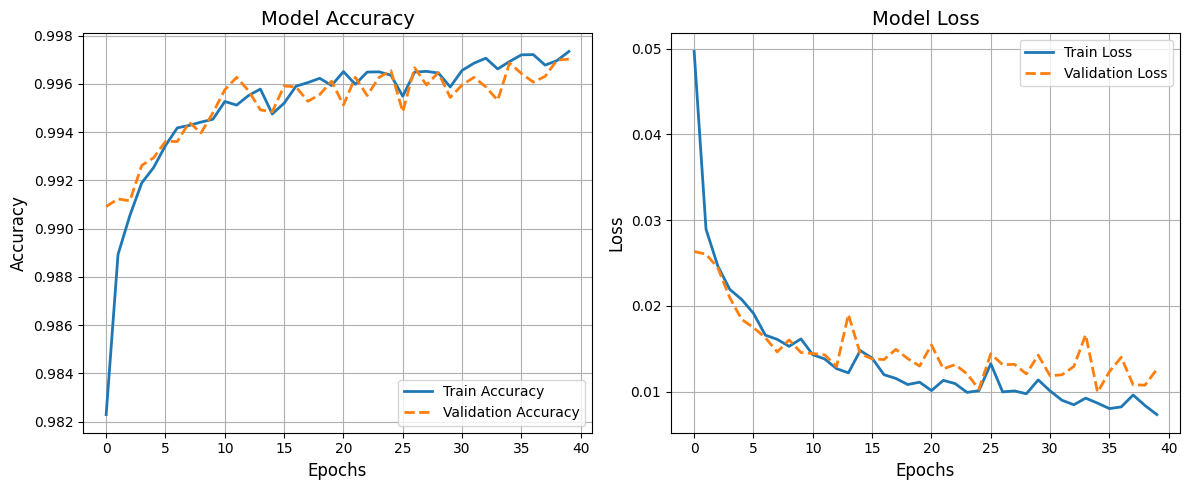

In [7]:
# Training History
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", linewidth=2)
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="--", linewidth=2)
plt.title("Model Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("visualization/training_accuracy.png")
plt.close()





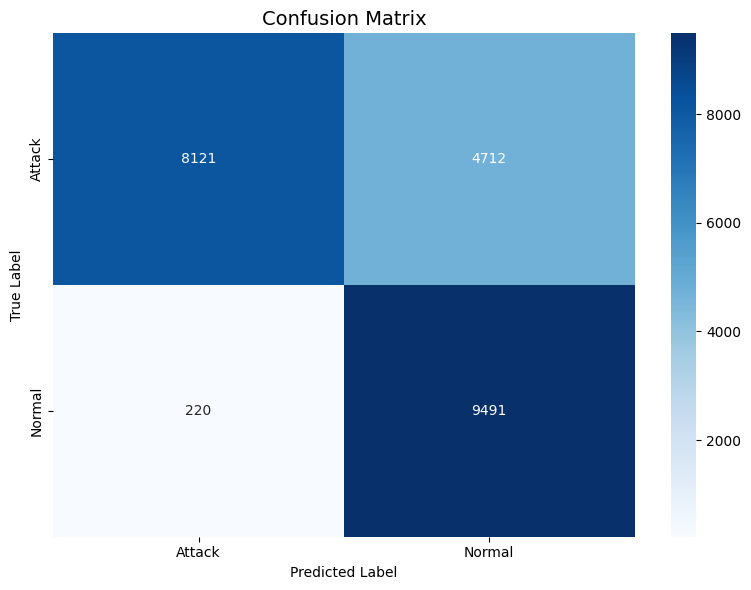

              precision    recall  f1-score   support

      Attack       0.97      0.63      0.77     12833
      Normal       0.67      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [8]:
# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("visualization/confusion_matrix.png")
plt.show()
plt.close()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

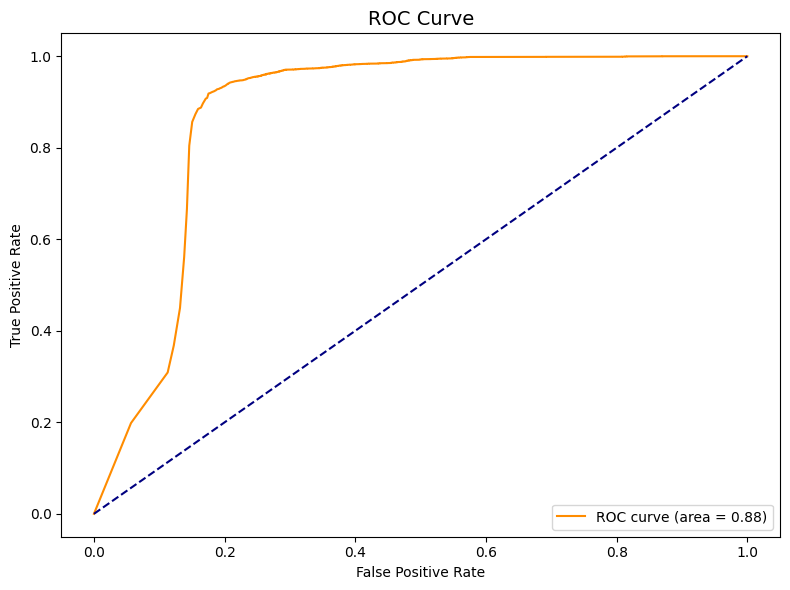

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("visualization/roc_curve.png")
plt.show()
plt.close()


## Step 6: SHAP Analysis

In [10]:
# # SHAP Analysis
# explainer = shap.Explainer(combined_model, x_train)
# shap_values = explainer(X_test)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test, feature_names=train.columns[:-1])
# plt.savefig("visualization/shap_summary_plot.png")
# plt.close()

# # SHAP Decision Plot
# shap.decision_plot(explainer.expected_value[0], shap_values.values, feature_names=train.columns[:-1])
# plt.savefig("visualization/shap_decision_plot.png")
# plt.close()

# # SHAP Force Plot (Single Instance)
# shap.force_plot(explainer.expected_value[0], shap_values.values[0], X_test[0], feature_names=train.columns[:-1], matplotlib=True)
# plt.savefig("visualization/shap_force_plot.png")
# plt.close()

71/71 [==============================] - 0s 912us/step


PermutationExplainer explainer:   9%|▉         | 9/100 [00:00<?, ?it/s]

71/71 [==============================] - 0s 805us/step


PermutationExplainer explainer:  11%|█         | 11/100 [00:11<00:45,  1.94it/s]

64/64 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  12%|█▏        | 12/100 [00:12<01:06,  1.33it/s]

76/76 [==============================] - 0s 737us/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [00:13<01:14,  1.18it/s]

75/75 [==============================] - 0s 775us/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [00:15<01:22,  1.04it/s]

72/72 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:16<01:26,  1.01s/it]

78/78 [==============================] - 0s 933us/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:17<01:29,  1.07s/it]

70/70 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:18<01:28,  1.07s/it]

60/60 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:19<01:25,  1.05s/it]

67/67 [==============================] - 0s 726us/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:20<01:23,  1.03s/it]

67/67 [==============================] - 0s 883us/step


PermutationExplainer explainer:  20%|██        | 20/100 [00:21<01:21,  1.01s/it]

73/73 [==============================] - 0s 850us/step


PermutationExplainer explainer:  21%|██        | 21/100 [00:22<01:22,  1.05s/it]

75/75 [==============================] - 0s 823us/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:23<01:23,  1.07s/it]

66/66 [==============================] - 0s 680us/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [00:24<01:18,  1.02s/it]

62/62 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [00:25<01:16,  1.01s/it]

73/73 [==============================] - 0s 917us/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [00:26<01:18,  1.04s/it]

76/76 [==============================] - 0s 709us/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [00:27<01:20,  1.09s/it]

72/72 [==============================] - 0s 813us/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [00:28<01:19,  1.10s/it]

71/71 [==============================] - 0s 840us/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [00:29<01:17,  1.07s/it]

59/59 [==============================] - 0s 681us/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [00:30<01:14,  1.04s/it]

65/65 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [00:32<01:13,  1.05s/it]

63/63 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [00:33<01:13,  1.07s/it]

82/82 [==============================] - 0s 834us/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [00:34<01:14,  1.09s/it]

69/69 [==============================] - 0s 885us/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [00:35<01:11,  1.07s/it]

75/75 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [00:36<01:13,  1.11s/it]

72/72 [==============================] - 0s 805us/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [00:37<01:11,  1.10s/it]

82/82 [==============================] - 0s 824us/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [00:38<01:11,  1.12s/it]

84/84 [==============================] - 0s 797us/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [00:40<01:14,  1.19s/it]

62/62 [==============================] - 0s 778us/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [00:41<01:11,  1.15s/it]

81/81 [==============================] - 0s 770us/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [00:42<01:11,  1.17s/it]

65/65 [==============================] - 0s 822us/step


PermutationExplainer explainer:  40%|████      | 40/100 [00:43<01:06,  1.10s/it]

73/73 [==============================] - 0s 892us/step


PermutationExplainer explainer:  41%|████      | 41/100 [00:44<01:02,  1.05s/it]

67/67 [==============================] - 0s 856us/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [00:45<00:58,  1.01s/it]

70/70 [==============================] - 0s 805us/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [00:46<00:57,  1.00s/it]

81/81 [==============================] - 0s 833us/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [00:47<00:58,  1.05s/it]

67/67 [==============================] - 0s 822us/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [00:48<00:55,  1.00s/it]

78/78 [==============================] - 0s 711us/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [00:49<00:57,  1.07s/it]

66/66 [==============================] - 0s 739us/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [00:50<00:54,  1.04s/it]

68/68 [==============================] - 0s 729us/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [00:51<00:50,  1.03it/s]

85/85 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [00:52<00:52,  1.02s/it]

81/81 [==============================] - 0s 899us/step


PermutationExplainer explainer:  50%|█████     | 50/100 [00:53<00:54,  1.09s/it]

65/65 [==============================] - 0s 725us/step


PermutationExplainer explainer:  51%|█████     | 51/100 [00:54<00:51,  1.04s/it]

70/70 [==============================] - 0s 701us/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [00:55<00:49,  1.02s/it]

68/68 [==============================] - 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [00:56<00:49,  1.06s/it]

71/71 [==============================] - 0s 676us/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [00:57<00:47,  1.04s/it]

75/75 [==============================] - 0s 779us/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [00:58<00:47,  1.05s/it]

79/79 [==============================] - 0s 722us/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [00:59<00:44,  1.01s/it]

70/70 [==============================] - 0s 822us/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [01:00<00:41,  1.03it/s]

76/76 [==============================] - 0s 742us/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [01:01<00:40,  1.04it/s]

71/71 [==============================] - 0s 776us/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [01:02<00:39,  1.03it/s]

73/73 [==============================] - 0s 737us/step


PermutationExplainer explainer:  60%|██████    | 60/100 [01:03<00:42,  1.05s/it]

62/62 [==============================] - 0s 876us/step


PermutationExplainer explainer:  61%|██████    | 61/100 [01:04<00:39,  1.01s/it]

70/70 [==============================] - 0s 835us/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [01:05<00:38,  1.01s/it]

74/74 [==============================] - 0s 815us/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [01:06<00:38,  1.04s/it]

64/64 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [01:07<00:37,  1.04s/it]

69/69 [==============================] - 0s 734us/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [01:08<00:35,  1.00s/it]

85/85 [==============================] - 0s 691us/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [01:09<00:35,  1.04s/it]

62/62 [==============================] - 0s 734us/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [01:10<00:32,  1.02it/s]

84/84 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [01:11<00:34,  1.09s/it]

75/75 [==============================] - 0s 974us/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [01:13<00:35,  1.14s/it]

69/69 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  70%|███████   | 70/100 [01:14<00:33,  1.13s/it]

61/61 [==============================] - 0s 718us/step


PermutationExplainer explainer:  71%|███████   | 71/100 [01:15<00:31,  1.07s/it]

77/77 [==============================] - 0s 891us/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [01:16<00:30,  1.08s/it]

72/72 [==============================] - 0s 828us/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [01:17<00:30,  1.12s/it]

68/68 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [01:18<00:28,  1.08s/it]

72/72 [==============================] - 0s 756us/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [01:19<00:26,  1.05s/it]

76/76 [==============================] - 0s 736us/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [01:20<00:25,  1.05s/it]

68/68 [==============================] - 0s 790us/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [01:21<00:23,  1.04s/it]

66/66 [==============================] - 0s 738us/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [01:22<00:21,  1.00it/s]

78/78 [==============================] - 0s 964us/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [01:23<00:21,  1.02s/it]

67/67 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [01:24<00:19,  1.00it/s]

68/68 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  81%|████████  | 81/100 [01:25<00:19,  1.02s/it]

80/80 [==============================] - 0s 767us/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [01:26<00:19,  1.10s/it]

72/72 [==============================] - 0s 885us/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [01:27<00:18,  1.09s/it]

71/71 [==============================] - 0s 835us/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [01:28<00:16,  1.05s/it]

76/76 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [01:29<00:15,  1.06s/it]

62/62 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [01:30<00:14,  1.03s/it]

72/72 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [01:32<00:15,  1.17s/it]

78/78 [==============================] - 0s 991us/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [01:33<00:14,  1.23s/it]

86/86 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [01:35<00:14,  1.34s/it]

66/66 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [01:36<00:12,  1.26s/it]

72/72 [==============================] - 0s 940us/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [01:37<00:10,  1.19s/it]

70/70 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [01:38<00:09,  1.21s/it]

61/61 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [01:39<00:08,  1.17s/it]

76/76 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [01:41<00:07,  1.20s/it]

74/74 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [01:42<00:06,  1.21s/it]

67/67 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [01:43<00:04,  1.18s/it]

67/67 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [01:44<00:03,  1.15s/it]

66/66 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [01:45<00:02,  1.17s/it]

73/73 [==============================] - 0s 1ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [01:46<00:01,  1.17s/it]

72/72 [==============================] - 0s 1ms/step


PermutationExplainer explainer: 100%|██████████| 100/100 [01:48<00:00,  1.20s/it]

76/76 [==============================] - 0s 1ms/step


PermutationExplainer explainer: 101it [01:49,  1.19s/it]                         


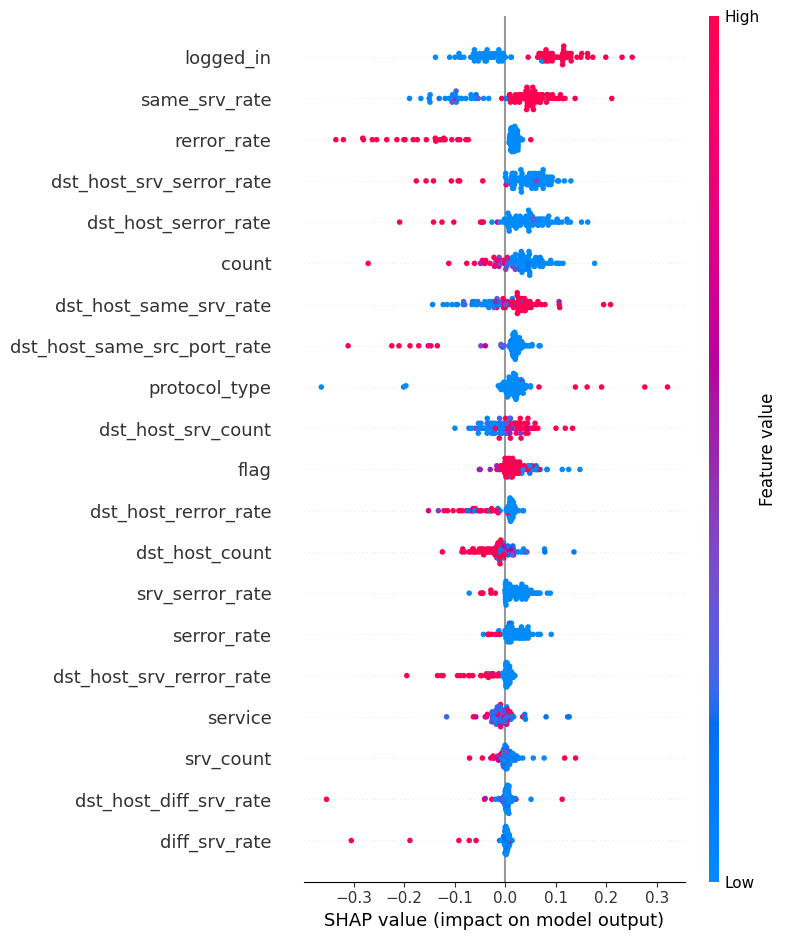

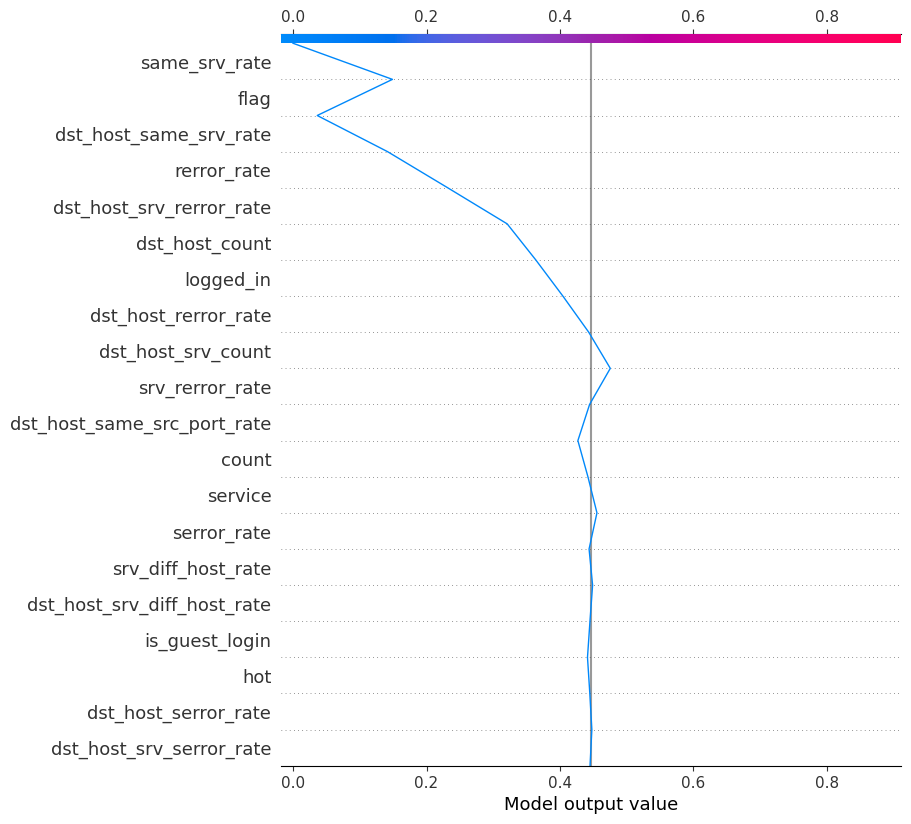

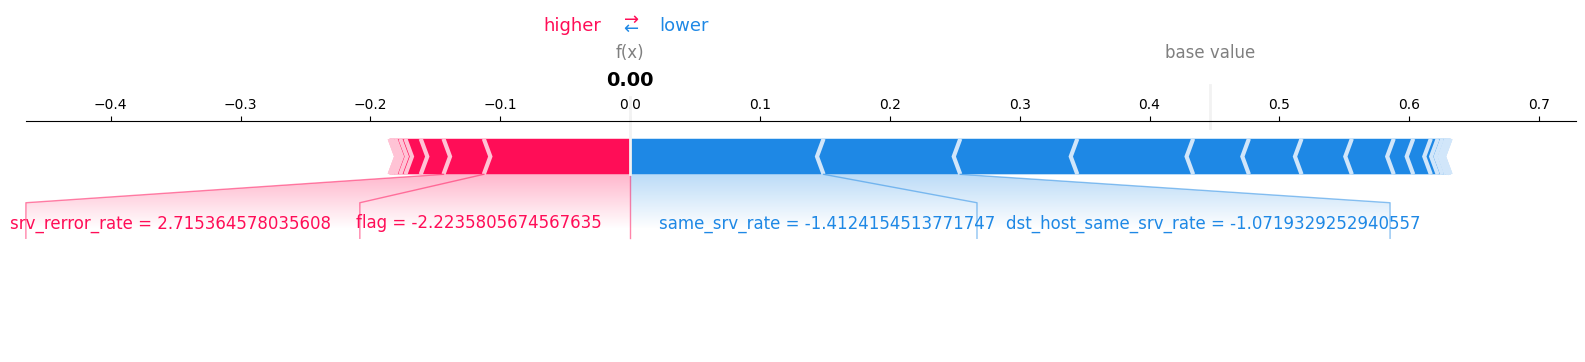

In [11]:
# SHAP Analysis with Partial Data
import shap

# Select a subset of the data for SHAP analysis
subset_size = 100  # Adjust the number of samples as needed
X_test_subset = X_test[:subset_size]
x_train_subset = x_train[:subset_size]

# Initialize the SHAP explainer using the subset of training data
explainer = shap.Explainer(combined_model.predict, x_train_subset)

# Generate SHAP values for the test subset
shap_values = explainer(X_test_subset)

# Define feature names explicitly as a list
feature_names = list(train.columns[:-1])  # Convert to list for SHAP compatibility

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
plt.savefig("visualization/shap_summary_plot.png")
plt.close()

# SHAP Decision Plot
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    feature_names=feature_names
)
plt.savefig("visualization/shap_decision_plot.png")
plt.close()

# SHAP Force Plot (Single Instance)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    X_test_subset[0], 
    feature_names=feature_names, 
    matplotlib=True
)
shap.save_html(
    "visualization/shap_force_plot.html", 
    shap.force_plot(
        shap_values.base_values[0], 
        shap_values.values[0], 
        X_test_subset[0], 
        feature_names=feature_names
    )
)
